<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:43] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


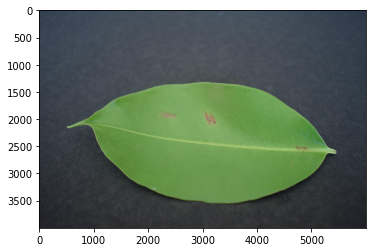

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

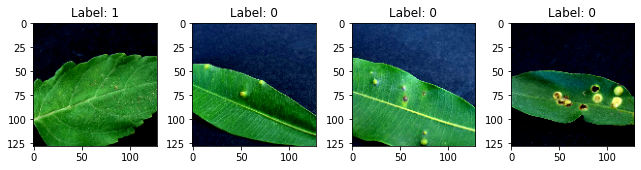

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:09:48] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:09:50] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2425850799130342 samples/sec                   batch loss = 1.8287571668624878 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2887032104097182 samples/sec                   batch loss = 0.903660774230957 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.287131208897317 samples/sec                   batch loss = 0.4367455244064331 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2896347737080238 samples/sec                   batch loss = 0.4302103817462921 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2884363919422654 samples/sec                   batch loss = 1.0295742750167847 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2945728335031166 samples/sec                   batch loss = 0.522847056388855 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2978509962156493 samples/sec                   batch loss = 1.7825725078582764 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.3001753745599167 samples/sec                   batch loss = 0.3498520851135254 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2913004552781853 samples/sec                   batch loss = 0.7336276769638062 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.2963682915040946 samples/sec                   batch loss = 0.5259817838668823 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.2918320031723665 samples/sec                   batch loss = 1.443341612815857 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.297587100679227 samples/sec                   batch loss = 0.6472273468971252 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.302190449091195 samples/sec                   batch loss = 0.3714311420917511 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.2964767845007759 samples/sec                   batch loss = 0.784833550453186 | accuracy = 0.6392857142857142


Epoch[1] Batch[75] Speed: 1.296553131177617 samples/sec                   batch loss = 0.5216156244277954 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2942379804315465 samples/sec                   batch loss = 0.6165047287940979 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2921081909686212 samples/sec                   batch loss = 1.109764575958252 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2916627273911505 samples/sec                   batch loss = 0.8830454349517822 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.290889417282153 samples/sec                   batch loss = 0.7604348063468933 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2888225029183844 samples/sec                   batch loss = 0.6203840970993042 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2943920532433681 samples/sec                   batch loss = 0.6976545453071594 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2915264041271655 samples/sec                   batch loss = 0.30586862564086914 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2910051411769088 samples/sec                   batch loss = 0.3583483099937439 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.294694214326278 samples/sec                   batch loss = 0.4133671820163727 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.287252482150986 samples/sec                   batch loss = 0.5488597750663757 | accuracy = 0.65


Epoch[1] Batch[130] Speed: 1.2942641392698846 samples/sec                   batch loss = 0.6031410694122314 | accuracy = 0.6480769230769231


Epoch[1] Batch[135] Speed: 1.2909009390746766 samples/sec                   batch loss = 0.4783233404159546 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.294161207351932 samples/sec                   batch loss = 0.5367514491081238 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.2969086323127772 samples/sec                   batch loss = 1.0023224353790283 | accuracy = 0.6517241379310345


Epoch[1] Batch[150] Speed: 1.2881626615921937 samples/sec                   batch loss = 0.5027533769607544 | accuracy = 0.6533333333333333


Epoch[1] Batch[155] Speed: 1.2937208117494279 samples/sec                   batch loss = 0.757143497467041 | accuracy = 0.65


Epoch[1] Batch[160] Speed: 1.2924675311869163 samples/sec                   batch loss = 0.2869514226913452 | accuracy = 0.6515625


Epoch[1] Batch[165] Speed: 1.295159068528835 samples/sec                   batch loss = 0.2273174524307251 | accuracy = 0.6575757575757576


Epoch[1] Batch[170] Speed: 1.294282710690073 samples/sec                   batch loss = 0.31192341446876526 | accuracy = 0.6573529411764706


Epoch[1] Batch[175] Speed: 1.2908012227870223 samples/sec                   batch loss = 1.0483131408691406 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.289086014668668 samples/sec                   batch loss = 0.489694207906723 | accuracy = 0.6569444444444444


Epoch[1] Batch[185] Speed: 1.3029257556223626 samples/sec                   batch loss = 0.6490016579627991 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2911244628111767 samples/sec                   batch loss = 0.912553071975708 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.293686195573656 samples/sec                   batch loss = 0.49399715662002563 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.2848781885755987 samples/sec                   batch loss = 0.42579740285873413 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.3052782135478307 samples/sec                   batch loss = 0.8543267846107483 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.295573931012754 samples/sec                   batch loss = 0.25550276041030884 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.3017208377397198 samples/sec                   batch loss = 0.5378374457359314 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2995565050381663 samples/sec                   batch loss = 1.250657320022583 | accuracy = 0.6568181818181819


Epoch[1] Batch[225] Speed: 1.2889321130954416 samples/sec                   batch loss = 0.3541376292705536 | accuracy = 0.6577777777777778


Epoch[1] Batch[230] Speed: 1.2919870955430524 samples/sec                   batch loss = 0.5038213133811951 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2878614651356126 samples/sec                   batch loss = 0.8007900714874268 | accuracy = 0.6595744680851063


Epoch[1] Batch[240] Speed: 1.2873297218177442 samples/sec                   batch loss = 0.6696783900260925 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.2901367748841432 samples/sec                   batch loss = 0.991078794002533 | accuracy = 0.6612244897959184


Epoch[1] Batch[250] Speed: 1.287715466210012 samples/sec                   batch loss = 0.6977665424346924 | accuracy = 0.664


Epoch[1] Batch[255] Speed: 1.2943387277177485 samples/sec                   batch loss = 0.8119903802871704 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.2930475753223079 samples/sec                   batch loss = 0.4556025266647339 | accuracy = 0.6634615384615384


Epoch[1] Batch[265] Speed: 1.2870618919435812 samples/sec                   batch loss = 0.7631290555000305 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.295978247435422 samples/sec                   batch loss = 0.9500183463096619 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.291132312384583 samples/sec                   batch loss = 0.72092205286026 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2915705494296708 samples/sec                   batch loss = 0.601782500743866 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2953951715127607 samples/sec                   batch loss = 0.6133129596710205 | accuracy = 0.6614035087719298


Epoch[1] Batch[290] Speed: 1.295689495720928 samples/sec                   batch loss = 0.7170180678367615 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2960619444278783 samples/sec                   batch loss = 1.0818873643875122 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2950673905735406 samples/sec                   batch loss = 0.3797111213207245 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.2921390405962263 samples/sec                   batch loss = 0.27070558071136475 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.293335649081244 samples/sec                   batch loss = 0.4496859014034271 | accuracy = 0.6661290322580645


Epoch[1] Batch[315] Speed: 1.290316269158185 samples/sec                   batch loss = 0.4918699562549591 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2891726871339502 samples/sec                   batch loss = 0.4850272536277771 | accuracy = 0.66875


Epoch[1] Batch[325] Speed: 1.298308676207285 samples/sec                   batch loss = 0.5349791049957275 | accuracy = 0.6692307692307692


Epoch[1] Batch[330] Speed: 1.2905537863692906 samples/sec                   batch loss = 0.35321319103240967 | accuracy = 0.6712121212121213


Epoch[1] Batch[335] Speed: 1.2957457346633896 samples/sec                   batch loss = 1.4438012838363647 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.290245914152109 samples/sec                   batch loss = 0.36351320147514343 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2866810781477094 samples/sec                   batch loss = 0.8770831823348999 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.2885757254875185 samples/sec                   batch loss = 1.2114840745925903 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2901338978259713 samples/sec                   batch loss = 0.162187859416008 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2930456818363987 samples/sec                   batch loss = 0.17358054220676422 | accuracy = 0.6770833333333334


Epoch[1] Batch[365] Speed: 1.2916216583463345 samples/sec                   batch loss = 1.127443552017212 | accuracy = 0.678082191780822


Epoch[1] Batch[370] Speed: 1.2892717556524507 samples/sec                   batch loss = 0.27452945709228516 | accuracy = 0.6777027027027027


Epoch[1] Batch[375] Speed: 1.2888711172364415 samples/sec                   batch loss = 0.2533862292766571 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2935259079256103 samples/sec                   batch loss = 0.954119086265564 | accuracy = 0.6769736842105263


Epoch[1] Batch[385] Speed: 1.2968223199286026 samples/sec                   batch loss = 0.28027334809303284 | accuracy = 0.6772727272727272


Epoch[1] Batch[390] Speed: 1.294455670151295 samples/sec                   batch loss = 0.2201005220413208 | accuracy = 0.6782051282051282


Epoch[1] Batch[395] Speed: 1.2960894786963009 samples/sec                   batch loss = 0.5425509810447693 | accuracy = 0.680379746835443


Epoch[1] Batch[400] Speed: 1.2971369493636788 samples/sec                   batch loss = 0.5143508315086365 | accuracy = 0.680625


Epoch[1] Batch[405] Speed: 1.2930376096692102 samples/sec                   batch loss = 0.7020674347877502 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.299154983237113 samples/sec                   batch loss = 1.6951848268508911 | accuracy = 0.6780487804878049


Epoch[1] Batch[415] Speed: 1.2959556230710965 samples/sec                   batch loss = 0.34598878026008606 | accuracy = 0.6771084337349398


Epoch[1] Batch[420] Speed: 1.2894154320527473 samples/sec                   batch loss = 1.036789894104004 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2904938281006202 samples/sec                   batch loss = 0.43616577982902527 | accuracy = 0.6794117647058824


Epoch[1] Batch[430] Speed: 1.2907757002773859 samples/sec                   batch loss = 3.503896713256836 | accuracy = 0.6790697674418604


Epoch[1] Batch[435] Speed: 1.2924709165046957 samples/sec                   batch loss = 0.6501153111457825 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.2969782118660111 samples/sec                   batch loss = 0.37738603353500366 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.2947695518142321 samples/sec                   batch loss = 0.6350514888763428 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.2929294922074586 samples/sec                   batch loss = 0.4796804189682007 | accuracy = 0.6811111111111111


Epoch[1] Batch[455] Speed: 1.2920872936707097 samples/sec                   batch loss = 0.2610127031803131 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.2873281413736197 samples/sec                   batch loss = 0.6847149729728699 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.2921490919220888 samples/sec                   batch loss = 0.7551167011260986 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2894575501697978 samples/sec                   batch loss = 1.3688825368881226 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2915242168257797 samples/sec                   batch loss = 0.4350455105304718 | accuracy = 0.6821052631578948


Epoch[1] Batch[480] Speed: 1.2891756589679813 samples/sec                   batch loss = 0.6843904852867126 | accuracy = 0.6822916666666666


Epoch[1] Batch[485] Speed: 1.2871890774854524 samples/sec                   batch loss = 0.6324125528335571 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.301391160474272 samples/sec                   batch loss = 0.6414597034454346 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2910917738419878 samples/sec                   batch loss = 0.1675719916820526 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.29081314025781 samples/sec                   batch loss = 0.4526575803756714 | accuracy = 0.6845


Epoch[1] Batch[505] Speed: 1.2947925344907623 samples/sec                   batch loss = 0.7113395929336548 | accuracy = 0.6841584158415842


Epoch[1] Batch[510] Speed: 1.285645591990524 samples/sec                   batch loss = 0.7868685722351074 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2941855660941786 samples/sec                   batch loss = 0.7818262577056885 | accuracy = 0.6839805825242719


Epoch[1] Batch[520] Speed: 1.2907315099917889 samples/sec                   batch loss = 0.7293381690979004 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.2962948711826938 samples/sec                   batch loss = 0.6099123954772949 | accuracy = 0.6842857142857143


Epoch[1] Batch[530] Speed: 1.2922091045769355 samples/sec                   batch loss = 0.9695675373077393 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.2966733803964243 samples/sec                   batch loss = 0.5645186901092529 | accuracy = 0.6841121495327103


Epoch[1] Batch[540] Speed: 1.2918294169571582 samples/sec                   batch loss = 0.3404190242290497 | accuracy = 0.6851851851851852


Epoch[1] Batch[545] Speed: 1.2879640894717028 samples/sec                   batch loss = 0.5867781639099121 | accuracy = 0.6853211009174311


Epoch[1] Batch[550] Speed: 1.2888350769423176 samples/sec                   batch loss = 0.5551091432571411 | accuracy = 0.6859090909090909


Epoch[1] Batch[555] Speed: 1.2884985341473059 samples/sec                   batch loss = 0.31316646933555603 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.283344065338713 samples/sec                   batch loss = 0.5887107253074646 | accuracy = 0.6875


Epoch[1] Batch[565] Speed: 1.2859905030935197 samples/sec                   batch loss = 0.4466106593608856 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.2929845949770389 samples/sec                   batch loss = 0.41381746530532837 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2917256784783195 samples/sec                   batch loss = 0.36446866393089294 | accuracy = 0.6891304347826087


Epoch[1] Batch[580] Speed: 1.2952372599842847 samples/sec                   batch loss = 0.30359527468681335 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.2930764765849965 samples/sec                   batch loss = 0.64316725730896 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2944425867285427 samples/sec                   batch loss = 0.6157470345497131 | accuracy = 0.6889830508474576


Epoch[1] Batch[595] Speed: 1.2839189934608752 samples/sec                   batch loss = 0.2739439010620117 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2826966850168093 samples/sec                   batch loss = 0.7346656918525696 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.2884265961861774 samples/sec                   batch loss = 0.9210702776908875 | accuracy = 0.6888429752066115


Epoch[1] Batch[610] Speed: 1.284893933091869 samples/sec                   batch loss = 0.38117238879203796 | accuracy = 0.6877049180327869


Epoch[1] Batch[615] Speed: 1.2882484185815906 samples/sec                   batch loss = 0.3153427839279175 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2845106637818824 samples/sec                   batch loss = 0.8401497602462769 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.2902077133079555 samples/sec                   batch loss = 0.36569449305534363 | accuracy = 0.6888


Epoch[1] Batch[630] Speed: 1.290672428831606 samples/sec                   batch loss = 0.3549550771713257 | accuracy = 0.6892857142857143


Epoch[1] Batch[635] Speed: 1.290729921183939 samples/sec                   batch loss = 0.4424823820590973 | accuracy = 0.6897637795275591


Epoch[1] Batch[640] Speed: 1.2935008759178788 samples/sec                   batch loss = 0.4440108835697174 | accuracy = 0.68984375


Epoch[1] Batch[645] Speed: 1.2872048786868946 samples/sec                   batch loss = 0.6449716091156006 | accuracy = 0.6903100775193799


Epoch[1] Batch[650] Speed: 1.2904148187585458 samples/sec                   batch loss = 0.726394534111023 | accuracy = 0.69


Epoch[1] Batch[655] Speed: 1.2823038462276317 samples/sec                   batch loss = 0.43608105182647705 | accuracy = 0.6900763358778625


Epoch[1] Batch[660] Speed: 1.2913901096355074 samples/sec                   batch loss = 0.1819259077310562 | accuracy = 0.690530303030303


Epoch[1] Batch[665] Speed: 1.2824921474453301 samples/sec                   batch loss = 0.7442095279693604 | accuracy = 0.6906015037593985


Epoch[1] Batch[670] Speed: 1.2856724884036548 samples/sec                   batch loss = 0.7151457667350769 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2912165771079644 samples/sec                   batch loss = 0.812018096446991 | accuracy = 0.6911111111111111


Epoch[1] Batch[680] Speed: 1.2895625105783963 samples/sec                   batch loss = 0.7724239826202393 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2919200401347115 samples/sec                   batch loss = 0.6183701753616333 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2882714671009328 samples/sec                   batch loss = 0.8683938980102539 | accuracy = 0.6905797101449276


Epoch[1] Batch[695] Speed: 1.2881299246226816 samples/sec                   batch loss = 0.8126257061958313 | accuracy = 0.6892086330935252


Epoch[1] Batch[700] Speed: 1.2879664624821743 samples/sec                   batch loss = 0.6465962529182434 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2891379176937108 samples/sec                   batch loss = 0.40574416518211365 | accuracy = 0.6897163120567376


Epoch[1] Batch[710] Speed: 1.282675992967812 samples/sec                   batch loss = 0.43370869755744934 | accuracy = 0.6890845070422535


Epoch[1] Batch[715] Speed: 1.2919870955430524 samples/sec                   batch loss = 0.3069664537906647 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2925176157859999 samples/sec                   batch loss = 0.7315472960472107 | accuracy = 0.690625


Epoch[1] Batch[725] Speed: 1.288114100702246 samples/sec                   batch loss = 0.506950855255127 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2936747237627106 samples/sec                   batch loss = 0.5440502166748047 | accuracy = 0.6924657534246575


Epoch[1] Batch[735] Speed: 1.2907677557332908 samples/sec                   batch loss = 0.9020729064941406 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2881151885843307 samples/sec                   batch loss = 0.269655704498291 | accuracy = 0.6929054054054054


Epoch[1] Batch[745] Speed: 1.2918074345459678 samples/sec                   batch loss = 0.4457828104496002 | accuracy = 0.6922818791946309


Epoch[1] Batch[750] Speed: 1.2933281714963298 samples/sec                   batch loss = 0.9717565178871155 | accuracy = 0.6923333333333334


Epoch[1] Batch[755] Speed: 1.2901416361495233 samples/sec                   batch loss = 0.7994644641876221 | accuracy = 0.6927152317880795


Epoch[1] Batch[760] Speed: 1.2861687468161467 samples/sec                   batch loss = 0.31903788447380066 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2903375061681908 samples/sec                   batch loss = 0.5575496554374695 | accuracy = 0.6944444444444444


Epoch[1] Batch[770] Speed: 1.28703592469391 samples/sec                   batch loss = 0.5646862983703613 | accuracy = 0.6944805194805195


Epoch[1] Batch[775] Speed: 1.284872579684892 samples/sec                   batch loss = 0.7906557321548462 | accuracy = 0.6951612903225807


Epoch[1] Batch[780] Speed: 1.2847336522676556 samples/sec                   batch loss = 0.4183424115180969 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2923066494741333 samples/sec                   batch loss = 0.5153518319129944 | accuracy = 0.6955414012738853


[Epoch 1] training: accuracy=0.6954314720812182
[Epoch 1] time cost: 638.8435122966766
[Epoch 1] validation: validation accuracy=0.7711111111111111


Epoch[2] Batch[5] Speed: 1.2936379155865285 samples/sec                   batch loss = 0.5566170811653137 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2984449277057122 samples/sec                   batch loss = 0.5982273817062378 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2993672859047534 samples/sec                   batch loss = 0.5336788296699524 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2918161876336354 samples/sec                   batch loss = 0.29072681069374084 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2991389878848738 samples/sec                   batch loss = 0.3789667785167694 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.294738276699842 samples/sec                   batch loss = 0.4495924115180969 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2963952377464139 samples/sec                   batch loss = 0.32886409759521484 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2920191333733633 samples/sec                   batch loss = 0.3135814666748047 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2901966007598504 samples/sec                   batch loss = 0.5970098972320557 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2994865479274862 samples/sec                   batch loss = 0.7972615957260132 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2955670277996207 samples/sec                   batch loss = 0.5375782251358032 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2937964350841735 samples/sec                   batch loss = 0.35719743371009827 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2934455296987137 samples/sec                   batch loss = 0.39706265926361084 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2959205868976291 samples/sec                   batch loss = 0.3072100281715393 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2881722555208839 samples/sec                   batch loss = 0.46387699246406555 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.295867135357168 samples/sec                   batch loss = 0.358495831489563 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.298185109976769 samples/sec                   batch loss = 0.8483142852783203 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2950584934040634 samples/sec                   batch loss = 0.24643902480602264 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.29424846380849 samples/sec                   batch loss = 0.34020209312438965 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.30033842311446 samples/sec                   batch loss = 0.38798755407333374 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.294023457951451 samples/sec                   batch loss = 1.3561452627182007 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.287438683040161 samples/sec                   batch loss = 0.6234382390975952 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2972031432473625 samples/sec                   batch loss = 0.5773988962173462 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2981286590883505 samples/sec                   batch loss = 0.39156240224838257 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.296923169210542 samples/sec                   batch loss = 1.0467849969863892 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2985785944958221 samples/sec                   batch loss = 0.3718092441558838 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2950116103393656 samples/sec                   batch loss = 0.3308171331882477 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.3002018747248334 samples/sec                   batch loss = 0.5604586005210876 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.3022662571997468 samples/sec                   batch loss = 0.3465777635574341 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.3009544060781866 samples/sec                   batch loss = 0.382964164018631 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2937302891234441 samples/sec                   batch loss = 0.24344530701637268 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2982330267715618 samples/sec                   batch loss = 0.6545004844665527 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.3044750296199181 samples/sec                   batch loss = 0.25454914569854736 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.3031908150659564 samples/sec                   batch loss = 0.9572808742523193 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.305298219497187 samples/sec                   batch loss = 0.6147310137748718 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2990818504720831 samples/sec                   batch loss = 0.5507605075836182 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.3055300082445684 samples/sec                   batch loss = 0.09070709347724915 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.3054767769043845 samples/sec                   batch loss = 0.29358166456222534 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.299650329850679 samples/sec                   batch loss = 0.8452087044715881 | accuracy = 0.7384615384615385


Epoch[2] Batch[200] Speed: 1.3043933863589592 samples/sec                   batch loss = 0.6088643074035645 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.3018611400655586 samples/sec                   batch loss = 0.2877998650074005 | accuracy = 0.7402439024390244


Epoch[2] Batch[210] Speed: 1.300240165844556 samples/sec                   batch loss = 0.8177206516265869 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.2990662592692879 samples/sec                   batch loss = 0.5468926429748535 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.302876277659652 samples/sec                   batch loss = 0.333274245262146 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.302958338255186 samples/sec                   batch loss = 0.30135494470596313 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.307837954283089 samples/sec                   batch loss = 0.13734236359596252 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.301963784966497 samples/sec                   batch loss = 0.21625597774982452 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.303869895401868 samples/sec                   batch loss = 0.3311702609062195 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.3053889140552093 samples/sec                   batch loss = 0.5442584156990051 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.3062388862707006 samples/sec                   batch loss = 0.6002667546272278 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.3066577236363761 samples/sec                   batch loss = 1.1911853551864624 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.3040984401700366 samples/sec                   batch loss = 0.2119416892528534 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.3018752830865243 samples/sec                   batch loss = 0.5887797474861145 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.3060410060613317 samples/sec                   batch loss = 0.20787346363067627 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.3047753213134097 samples/sec                   batch loss = 0.8231762647628784 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.3043132743361456 samples/sec                   batch loss = 0.3953767716884613 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.302604064317703 samples/sec                   batch loss = 0.616491973400116 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.3019104399270778 samples/sec                   batch loss = 0.6220791935920715 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.3055112142413043 samples/sec                   batch loss = 0.606833279132843 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.2989296762163132 samples/sec                   batch loss = 0.4506032168865204 | accuracy = 0.7441666666666666


Epoch[2] Batch[305] Speed: 1.3030653057445667 samples/sec                   batch loss = 0.4085381031036377 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.2997906896766245 samples/sec                   batch loss = 0.4722490906715393 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.3028526024178682 samples/sec                   batch loss = 0.6173129081726074 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2988160465236003 samples/sec                   batch loss = 0.4925183057785034 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.3005252032524106 samples/sec                   batch loss = 0.6496962308883667 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.2940393275833384 samples/sec                   batch loss = 0.9234405755996704 | accuracy = 0.7446969696969697


Epoch[2] Batch[335] Speed: 1.2898942541743998 samples/sec                   batch loss = 0.3178423345088959 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.2960514316521858 samples/sec                   batch loss = 0.20186035335063934 | accuracy = 0.7455882352941177


Epoch[2] Batch[345] Speed: 1.2997066111041562 samples/sec                   batch loss = 0.5773512125015259 | accuracy = 0.7442028985507246


Epoch[2] Batch[350] Speed: 1.2982223782892532 samples/sec                   batch loss = 0.7918578386306763 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2898289032505468 samples/sec                   batch loss = 0.4085599482059479 | accuracy = 0.7415492957746479


Epoch[2] Batch[360] Speed: 1.2958544237484415 samples/sec                   batch loss = 0.5189173221588135 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.3008258978952045 samples/sec                   batch loss = 0.6228200793266296 | accuracy = 0.7397260273972602


Epoch[2] Batch[370] Speed: 1.297273055335248 samples/sec                   batch loss = 0.4686448574066162 | accuracy = 0.7391891891891892


Epoch[2] Batch[375] Speed: 1.2987713040031708 samples/sec                   batch loss = 0.29879382252693176 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.296985330656266 samples/sec                   batch loss = 0.3909212350845337 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2917212030799496 samples/sec                   batch loss = 0.5523843169212341 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2942515589332024 samples/sec                   batch loss = 0.5052278637886047 | accuracy = 0.7403846153846154


Epoch[2] Batch[395] Speed: 1.2992774261178583 samples/sec                   batch loss = 0.9092045426368713 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.293243331889049 samples/sec                   batch loss = 0.4760432541370392 | accuracy = 0.7375


Epoch[2] Batch[405] Speed: 1.2889765763772365 samples/sec                   batch loss = 0.46206432580947876 | accuracy = 0.7376543209876543


Epoch[2] Batch[410] Speed: 1.2923302416249767 samples/sec                   batch loss = 0.9190980195999146 | accuracy = 0.7378048780487805


Epoch[2] Batch[415] Speed: 1.293114349160735 samples/sec                   batch loss = 0.39393797516822815 | accuracy = 0.7385542168674699


Epoch[2] Batch[420] Speed: 1.2953786685065434 samples/sec                   batch loss = 0.5861192345619202 | accuracy = 0.7392857142857143


Epoch[2] Batch[425] Speed: 1.2954445830273387 samples/sec                   batch loss = 0.3853580355644226 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.2938432302030345 samples/sec                   batch loss = 0.8236754536628723 | accuracy = 0.7412790697674418


Epoch[2] Batch[435] Speed: 1.2902848118813266 samples/sec                   batch loss = 1.0378562211990356 | accuracy = 0.7419540229885058


Epoch[2] Batch[440] Speed: 1.2946415632234856 samples/sec                   batch loss = 1.0434939861297607 | accuracy = 0.7403409090909091


Epoch[2] Batch[445] Speed: 1.2956555745911753 samples/sec                   batch loss = 0.19000205397605896 | accuracy = 0.7426966292134831


Epoch[2] Batch[450] Speed: 1.3007045747742383 samples/sec                   batch loss = 0.31205692887306213 | accuracy = 0.7438888888888889


Epoch[2] Batch[455] Speed: 1.2947778454686292 samples/sec                   batch loss = 0.23399721086025238 | accuracy = 0.7445054945054945


Epoch[2] Batch[460] Speed: 1.2960558369850501 samples/sec                   batch loss = 0.8083210587501526 | accuracy = 0.7429347826086956


Epoch[2] Batch[465] Speed: 1.299178323074084 samples/sec                   batch loss = 0.1616603136062622 | accuracy = 0.7435483870967742


Epoch[2] Batch[470] Speed: 1.3035155307637591 samples/sec                   batch loss = 0.7411949634552002 | accuracy = 0.7430851063829788


Epoch[2] Batch[475] Speed: 1.2965753756016978 samples/sec                   batch loss = 0.38263335824012756 | accuracy = 0.7442105263157894


Epoch[2] Batch[480] Speed: 1.2949393430959248 samples/sec                   batch loss = 0.4489835500717163 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.3000910447221068 samples/sec                   batch loss = 0.2792571187019348 | accuracy = 0.7422680412371134


Epoch[2] Batch[490] Speed: 1.3012015076587407 samples/sec                   batch loss = 0.31917470693588257 | accuracy = 0.7423469387755102


Epoch[2] Batch[495] Speed: 1.3045294979503903 samples/sec                   batch loss = 0.43091917037963867 | accuracy = 0.7419191919191919


Epoch[2] Batch[500] Speed: 1.3005890211761415 samples/sec                   batch loss = 0.7758684158325195 | accuracy = 0.742


Epoch[2] Batch[505] Speed: 1.3025084979879968 samples/sec                   batch loss = 0.8098753690719604 | accuracy = 0.7415841584158416


Epoch[2] Batch[510] Speed: 1.306943953025719 samples/sec                   batch loss = 0.6598414182662964 | accuracy = 0.7397058823529412


Epoch[2] Batch[515] Speed: 1.310373877025139 samples/sec                   batch loss = 0.4641205668449402 | accuracy = 0.7398058252427184


Epoch[2] Batch[520] Speed: 1.3067790402724533 samples/sec                   batch loss = 0.23604317009449005 | accuracy = 0.7403846153846154


Epoch[2] Batch[525] Speed: 1.302936380214882 samples/sec                   batch loss = 0.7448408007621765 | accuracy = 0.7404761904761905


Epoch[2] Batch[530] Speed: 1.3067237732730645 samples/sec                   batch loss = 0.45265790820121765 | accuracy = 0.7396226415094339


Epoch[2] Batch[535] Speed: 1.2958738415819453 samples/sec                   batch loss = 0.19761653244495392 | accuracy = 0.7406542056074766


Epoch[2] Batch[540] Speed: 1.2951086790385766 samples/sec                   batch loss = 0.3084399104118347 | accuracy = 0.7421296296296296


Epoch[2] Batch[545] Speed: 1.2949390432486474 samples/sec                   batch loss = 0.20537079870700836 | accuracy = 0.7440366972477064


Epoch[2] Batch[550] Speed: 1.2945029124976062 samples/sec                   batch loss = 0.12708735466003418 | accuracy = 0.7436363636363637


Epoch[2] Batch[555] Speed: 1.2936847989944906 samples/sec                   batch loss = 0.6556609272956848 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.2946586468880787 samples/sec                   batch loss = 0.24293150007724762 | accuracy = 0.7464285714285714


Epoch[2] Batch[565] Speed: 1.3042760610856985 samples/sec                   batch loss = 0.6580041646957397 | accuracy = 0.745575221238938


Epoch[2] Batch[570] Speed: 1.2993096252844551 samples/sec                   batch loss = 0.3114805519580841 | accuracy = 0.7460526315789474


Epoch[2] Batch[575] Speed: 1.298456283288138 samples/sec                   batch loss = 0.2638186514377594 | accuracy = 0.7447826086956522


Epoch[2] Batch[580] Speed: 1.2891316772234718 samples/sec                   batch loss = 0.5481598377227783 | accuracy = 0.7452586206896552


Epoch[2] Batch[585] Speed: 1.3032100484691267 samples/sec                   batch loss = 0.2046300321817398 | accuracy = 0.7448717948717949


Epoch[2] Batch[590] Speed: 1.295664379905498 samples/sec                   batch loss = 0.5393047332763672 | accuracy = 0.7444915254237288


Epoch[2] Batch[595] Speed: 1.2993475619753392 samples/sec                   batch loss = 0.32469648122787476 | accuracy = 0.7445378151260504


Epoch[2] Batch[600] Speed: 1.299320492863394 samples/sec                   batch loss = 0.3570198118686676 | accuracy = 0.74375


Epoch[2] Batch[605] Speed: 1.2968337473892833 samples/sec                   batch loss = 0.5202344655990601 | accuracy = 0.743801652892562


Epoch[2] Batch[610] Speed: 1.2958373085117427 samples/sec                   batch loss = 0.6354327201843262 | accuracy = 0.7442622950819672


Epoch[2] Batch[615] Speed: 1.2978168614230703 samples/sec                   batch loss = 1.1733771562576294 | accuracy = 0.7439024390243902


Epoch[2] Batch[620] Speed: 1.2956197542053236 samples/sec                   batch loss = 0.12149221450090408 | accuracy = 0.7435483870967742


Epoch[2] Batch[625] Speed: 1.2965801853072625 samples/sec                   batch loss = 0.27797532081604004 | accuracy = 0.7448


Epoch[2] Batch[630] Speed: 1.2983295742854037 samples/sec                   batch loss = 0.07235530018806458 | accuracy = 0.7436507936507937


Epoch[2] Batch[635] Speed: 1.2982845638761789 samples/sec                   batch loss = 1.3052536249160767 | accuracy = 0.7437007874015747


Epoch[2] Batch[640] Speed: 1.302305781994009 samples/sec                   batch loss = 0.427990585565567 | accuracy = 0.743359375


Epoch[2] Batch[645] Speed: 1.3030056972854696 samples/sec                   batch loss = 0.23738767206668854 | accuracy = 0.7445736434108527


Epoch[2] Batch[650] Speed: 1.301257721488827 samples/sec                   batch loss = 0.24329471588134766 | accuracy = 0.7453846153846154


Epoch[2] Batch[655] Speed: 1.2998316756308987 samples/sec                   batch loss = 0.4858093857765198 | accuracy = 0.7461832061068703


Epoch[2] Batch[660] Speed: 1.29924200887782 samples/sec                   batch loss = 0.320416659116745 | accuracy = 0.7450757575757576


Epoch[2] Batch[665] Speed: 1.2999498142305208 samples/sec                   batch loss = 0.6133280992507935 | accuracy = 0.7443609022556391


Epoch[2] Batch[670] Speed: 1.2993698017551374 samples/sec                   batch loss = 0.4649757146835327 | accuracy = 0.7432835820895523


Epoch[2] Batch[675] Speed: 1.2941168847798017 samples/sec                   batch loss = 0.6914980411529541 | accuracy = 0.7425925925925926


Epoch[2] Batch[680] Speed: 1.29790380828559 samples/sec                   batch loss = 0.44245657324790955 | accuracy = 0.7426470588235294


Epoch[2] Batch[685] Speed: 1.2967296045578256 samples/sec                   batch loss = 1.051162600517273 | accuracy = 0.7416058394160584


Epoch[2] Batch[690] Speed: 1.2942758212300778 samples/sec                   batch loss = 0.2711220979690552 | accuracy = 0.7427536231884058


Epoch[2] Batch[695] Speed: 1.2979081258121492 samples/sec                   batch loss = 0.25757500529289246 | accuracy = 0.7431654676258993


Epoch[2] Batch[700] Speed: 1.2980054283888862 samples/sec                   batch loss = 0.18876032531261444 | accuracy = 0.7439285714285714


Epoch[2] Batch[705] Speed: 1.2986722781508575 samples/sec                   batch loss = 0.5148740410804749 | accuracy = 0.7443262411347518


Epoch[2] Batch[710] Speed: 1.2928747926568247 samples/sec                   batch loss = 0.4000703990459442 | accuracy = 0.7447183098591549


Epoch[2] Batch[715] Speed: 1.2931634871507744 samples/sec                   batch loss = 0.6927341818809509 | accuracy = 0.7451048951048951


Epoch[2] Batch[720] Speed: 1.294172388300098 samples/sec                   batch loss = 0.26277533173561096 | accuracy = 0.7465277777777778


Epoch[2] Batch[725] Speed: 1.3017016482680925 samples/sec                   batch loss = 0.464738667011261 | accuracy = 0.7472413793103448


Epoch[2] Batch[730] Speed: 1.299016772253167 samples/sec                   batch loss = 0.5076541900634766 | accuracy = 0.7472602739726028


Epoch[2] Batch[735] Speed: 1.3004004084151883 samples/sec                   batch loss = 0.17509350180625916 | accuracy = 0.746938775510204


Epoch[2] Batch[740] Speed: 1.2996274764219455 samples/sec                   batch loss = 0.56427001953125 | accuracy = 0.7469594594594594


Epoch[2] Batch[745] Speed: 1.3089090016859486 samples/sec                   batch loss = 0.6010729074478149 | accuracy = 0.7476510067114094


Epoch[2] Batch[750] Speed: 1.2983796118408033 samples/sec                   batch loss = 0.36353403329849243 | accuracy = 0.748


Epoch[2] Batch[755] Speed: 1.298262160304565 samples/sec                   batch loss = 0.47022879123687744 | accuracy = 0.7483443708609272


Epoch[2] Batch[760] Speed: 1.2992037765246496 samples/sec                   batch loss = 0.271505206823349 | accuracy = 0.7493421052631579


Epoch[2] Batch[765] Speed: 1.29558653707004 samples/sec                   batch loss = 0.3817269504070282 | accuracy = 0.75


Epoch[2] Batch[770] Speed: 1.2974734047283818 samples/sec                   batch loss = 0.7931755781173706 | accuracy = 0.75


Epoch[2] Batch[775] Speed: 1.2998767933799724 samples/sec                   batch loss = 0.6870144605636597 | accuracy = 0.7503225806451613


Epoch[2] Batch[780] Speed: 1.3056451206217832 samples/sec                   batch loss = 0.5496940016746521 | accuracy = 0.7496794871794872


Epoch[2] Batch[785] Speed: 1.3048832977866036 samples/sec                   batch loss = 0.2795182168483734 | accuracy = 0.7487261146496815


[Epoch 2] training: accuracy=0.7484137055837563
[Epoch 2] time cost: 624.1100096702576
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)